# Analyzing Bay Wheels Trip Statistics for San Francisco Bay Area 2017-2018

## Creator: Tom Esposito, espos13@gmail.com, http://w.astro.berkeley.edu/~tesposito/

### This notebook analyzes ride data from the Lyft Bay Wheels (formerly Ford GoBike) bikeshare program operated in the San Francisco Bay Area by Motivate starting in 2017. My statistical analysis focuses on the city of Berkeley, where I live, but extends to Oakland, Emeryville, San Francisco, and San Jose. It uses publicly available data from https://www.lyft.com/bikes/bay-wheels/system-data and open-source Python code to examine ridership and system usage.

### Acknowledgements: Thank you to Motivate for making their data public and nicely packaged. Special thanks to the authors and developers of the public Python packages `geocoder` (https://github.com/DenisCarriere/geocoder), `gmplot` (https://github.com/vgm64/gmplot), `requests` (http://docs.python-requests.org/en/master/), `astropy` (http://www.astropy.org), and `matplotlib` (https://matplotlib.org).

#### Disclaimer: This work is conducted purely to satisfy personal curiosity. I am not affiliated with Motivate, its parent company Lyft, Inc., or Ford Motor Company, nor am I affiliated with any of the municipalities participating in the Bay Wheels/GoBike programs apart from being a resident of Berkeley. Any similarities between this and other analyses of Bay Wheels/GoBike data are purely coincidental (and evidence that great minds think alike).

## Load and parse the data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from datetime import datetime
import requests
from glob import glob
import sqlite3
import geocoder
from gmplot import gmplot
# I'm using table-handling functions from astropy, an astronomy-related module, because I'm
# familiar with it, but there are other options out there.
from astropy import table
from astropy.io import ascii

from gobike_utils import GoBike

# Set some plotting defaults.
font = {'size' : 14}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

We have ride data as comma-separated tables with annual totals for 2017 (not intrinsically broken down by month) and monthly totals for 2018 through October 2019. That gives us data for 23 different epochs, i.e. periods of time.

In [2]:
# Get the paths to available .csv tables containing GoBike data based on epoch names.
fns = glob('*-tripdata.csv')
epoch_names = np.sort([fn.split('-')[0] for fn in fns])
N_ep = len(epoch_names)
print("Loading %d epochs of data..." % N_ep)

# Create a GoBike class object to hold the data. Initializing it with the list of epochs will read the raw data
# into handy tables (using astropy.io.ascii). 'NULL' empty entries are converted to -1 for easier handling later.
# This will take ~10 seconds.
gb = GoBike(epoch_names)
tables = gb.tables

Loading 23 epochs of data...
Epochs loaded: ['2017' '201801' '201802' '201803' '201804' '201805' '201806' '201807'
 '201808' '201809' '201810' '201811' '201812' '201901' '201902' '201903'
 '201904' '201905' '201906' '201907' '201908' '201909' '201910']


For assessing trip statistics city-by-city, I want to know which city each station is in. Unfortunately, the city name is not included with the station names. But we do have the station latitudes and longitudes! With the help of the `geocoder` module and a geocoding API we can use those coordinates to match a city to each station. In this case, we used the [Nominatim](https://nominatim.openstreetmap.org) server connected to the open-license [OpenStreetMap](https://www.openstreetmap.org/#map=10/37.6523/-122.2998) to reverse geocode every unique (latitude,longitude) pair and fetch the city name.

We did this once and saved the result in a table named "stations.tsv" to avoid repeated querying, which is slow and a burden on the Nominatim servers. See the commented code below for the method. If you wish to do your own queries, please read and abide by the [Nominatim usage policy](https://operations.osmfoundation.org/policies/nominatim/) so they can keep providing this free service.

In [3]:
# Load the table of stations and city names created ahead of time.
# Column names: 'id', 'name', 'city', 'lat', 'lon'
stations = ascii.read("stations.tsv", Reader=ascii.Basic,
                      delimiter='\t', header_start=0, data_start=1)

conn = sqlite3.connect("gobike_sql.db")

cursor = conn.cursor()

cursor.execute("""
                CREATE TABLE ep0 (
                duration_sec,
                start_time,
                end_time,
                start_station_id,
                start_station_name,
                start_station_latitude,
                start_station_longitude,
                end_station_id,
                end_station_name,
                end_station_latitude,
                end_station_longitude,
                bike_id,
                user_type,
                member_birth_year,
                member_gender,
                bike_share_for_all_trip)
                """)

import csv

with open('%s-fordgobike-tripdata.csv' % '201801', 'r') as ff:
    data = csv.reader(ff)
    
    for row in data:
        cursor.execute("INSERT INTO ep0")

```
# ----- EXAMPLE REVERSE GEOCODING ----- #

# Get all unique station latitude,longitude coordinate pairs from the most recent epoch,
# by the reasoning that stations have been added over time but not taken away.
# This is slightly slow due to the repeated table lookup; it takes ~25 seconds.

tab_1806 = tables[-1]
start_stations = np.unique(np.array(tab_1806['start_station_id', 'start_station_latitude', 'start_station_longitude', 'start_station_name']))
end_stations = np.unique(np.array(tab_1806['end_station_id', 'end_station_latitude', 'end_station_longitude', 'end_station_name']))

# Make a new empty table to hold all of our station info.
stations = table.Table(names=['id', 'name', 'city', 'lat', 'lon'],
                       dtype=['int64', 'U80', 'U50', 'float64', 'float64'])

# Loop through the starting stations to find out which cities they're in.
# This could take up to 1 hour or more for ~300 station queries.
# First, create a persistent HTTP connection with requests.Session to reuse the same
# TCP connection for every query to Nominatim and speed things up (maybe).

with requests.Session() as session:
    for st in start_stations:
        if st[0] != -1:
            sid = st[0]
            lat = st[1]
            lon = st[2]
            geo = geocoder.osm('%s,%s' % (lat, lon), method='reverse', session=session)
            # Nominatim returns the city name in one of several class attributes. Use whichever is not None.
            # E.g., Emeryville is a 'town' instead of a 'city', despite it actually being the latter.
            city_names = np.array([geo.current_result.city, geo.current_result.town,
                                   geo.current_result.village, geo.current_result.municipality])
            city = city_names[np.argwhere(city_names)[0][0]] # string name of city
            stations.add_row([sid, st[3], city, lat, lon])
            print(geo)
            # The Nominatim rate limit for bulk queries is 1/second, so make sure we stay below that limit.
            time.sleep(1)

    # Loop through the end stations to add any not included in the starting stations.
    for st in end_stations:
        if ((st[0] != -1) & (st[0] not in stations['id'])):
            print("Found new end station")
            sid = st[0]
            lat = st[1]
            lon = st[2]
            geo = geocoder.osm('%s,%s' % (lat, lon), method='reverse', session=session)
            city_names = np.array([geo.current_result.city, geo.current_result.town,
                                   geo.current_result.village, geo.current_result.municipality])
            city = city_names[np.argwhere(city_names)[0][0]]
            stations.add_row([sid, st[3], city, lat, lon])
            print(geo)
            time.sleep(1)

# Write the new table to a file to avoid geocoding again.
stations.write('stations.tsv', format='ascii.tab')
```

In [4]:
# Add the city names of the starting and ending stations as new columns in each table
# so we have them handy later.
# Doing this station-by-station with for loops is slow but effective.
for tab in tables:
    if 'start_city' not in tab.keys():
        tab.add_column(table.Column(len(tab)*[''], name='start_city', dtype='U50'))
    if 'end_city' not in tab.keys():
        tab.add_column(table.Column(len(tab)*[''], name='end_city', dtype='U50'))
    
    for row in stations:
        row_id = row['id']
        row_city = row['city']
        tab['start_city'][tab['start_station_id']==row_id] = row_city
        tab['end_city'][tab['end_station_id']==row_id] = row_city

In [5]:
# FIX ME!!! This takes ~60 seconds for 16 epochs. Speed it up.

# I'd like to compare weekday trips to weekend trips at some point. This will require parsing the
# "start_time" and "end_time" strings into new table columns for day and 24-hour time.
# Writing to table elements is slow, so we'll stage our new entries in arrays and put them
# into the table columns only as a final step.

#timest = time.time()

# The datetime.weekday() method returns an integer 0-6 with 0 = Monday and 6 = Sunday.
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for jj, tab in enumerate(tables):
    # Parsing the timestamp string manually is about 3x faster than having datetime.strptime parse 
    # it automatically. If this step fails (e.g., if GoBike changes the format of their timestamp string),
    # try using the strptime strategy below instead (but expect it to take 2--5 min).
    # Ignore fractions of a second- we don't need that level of precision and some timestamps lack it.
    #start_dt = [datetime(int(st[0:4]), int(st[5:7]), int(st[8:10]), int(st[11:13]), int(st[14:16]),
    #                     int(st[17:19]), int(st[20:])) for st in tab['start_time'].data]
    start_dt = [datetime(int(st[0:4]), int(st[5:7]), int(st[8:10]), int(st[11:13]), int(st[14:16]),
                         int(st[17:19])) for st in tab['start_time'].data]
    #start_dt = [datetime.strptime(st, "%Y-%m-%d %H:%M:%S") for st in tab['start_time'].data]
    start_days = np.array([days_of_week[ii.weekday()] for ii in start_dt])
    start_hrs = np.array([ii.hour + ii.minute/60. for ii in start_dt])
        
    #end_dt = [datetime(int(et[0:4]), int(et[5:7]), int(et[8:10]), int(et[11:13]), int(et[14:16]),
    #                   int(et[17:19]), int(et[20:])) for et in tab['end_time'].data]
    end_dt = [datetime(int(et[0:4]), int(et[5:7]), int(et[8:10]), int(et[11:13]), int(et[14:16]),
                       int(et[17:19])) for et in tab['end_time'].data]
    #end_dt = [datetime.strptime(et, "%Y-%m-%d %H:%M:%S") for et in tab['end_time'].data]
    end_days = np.array([days_of_week[ii.weekday()] for ii in end_dt])
    end_hrs = np.array([ii.hour + ii.minute/60. for ii in end_dt])
    
    tab.add_column(table.Column(start_days, name='start_day', dtype='U50'))
    tab.add_column(table.Column(start_hrs, name='start_hr', dtype='float32'))
    tab.add_column(table.Column(end_days, name='end_day', dtype='U50'))
    tab.add_column(table.Column(end_hrs, name='end_hr', dtype='float32'))

    
#print("Elapsed:", time.time() - timest)

In [6]:
# Separate out the stations that are in Berkeley.
berk_stations = stations[stations['city'] == 'Berkeley']
berk_ids = berk_stations['id'].tolist()

In [7]:
# Define a function to separate the trips involving a single city in a trip table
# from a given epoch.
def sep_city(tab, city_ids):
    wh_start = []
    wh_end = []
    for sid in city_ids:
        wh_start += (np.where(tab['start_station_id'] == sid)[0].tolist())
        wh_end += (np.where(tab['end_station_id'] == sid)[0].tolist())
    
    city_start = tab[wh_start]
    city_end = tab[wh_end]
    
    # Combine the Berkeley start and end trips to get all trips starting or ending in the city.
    wh_city = np.unique(wh_start + wh_end)
    city_trips = tab[wh_city]
    
    # And find the trips that both started AND ended in Berkeley.
    wh_city_only = np.array(wh_start)[np.in1d(wh_start, wh_end)]
    city_only = tab[wh_city_only]
    
    return city_trips, city_only, city_start, city_end

In [8]:
# Now we can easily separate out the trips that start and/or end in Berkeley.
# berk_trip_list will be a list of tuples of tables for each epoch of data.
berk_trip_list = []
for ii, tab in enumerate(tables):
    berk_trip_list.append(sep_city(tab, berk_ids))

Before going further we will do some basic accounting to make sure the city trip numbers make sense. For reference, the 2010 census listed Berkeley's population at 112,580.

To put the 2017 data on the same scale as the later data, we'll divide the 2017 numbers by 6 to get a monthly average for that year (the program started that June 28).

In [9]:
# Let's do some simple accounting to make sure these trip numbers make sense.
# Population of Berkeley from 2010 census.
pop_berk = 112580

n_berk_trips = []
n_berk_only = []
n_berk_start = []
n_berk_end = []
for ii in range(len(berk_trip_list)):
    n_berk_trips.append(len(berk_trip_list[ii][0]))
    n_berk_only.append(len(berk_trip_list[ii][1]))
    n_berk_start.append(len(berk_trip_list[ii][2]))
    n_berk_end.append(len(berk_trip_list[ii][3]))
    
    # Divide 2017 data by 6 months to convert to a one-month average.
    if ii == 0:
        n_berk_trips[ii] /= 6.
        n_berk_only[ii] /= 6.
        n_berk_start[ii] /= 6.
        n_berk_end[ii] /= 6.
    
    #print(epoch_names[ii].split('-')[0])
    #print("# trips starting in Berkeley = %d" % n_berk_start[ii])
    #print("# trips ending in Berkeley   = %d" % n_berk_end[ii])
    #print("# trips starting OR ending in Berkeley  = %d" % n_berk_trips[ii])
    #print("# trips starting AND ending in Berkeley = %d" % n_berk_only[ii])

### Berkeley Trip Numbers

Now we can examine actual numbers for trips related to Berkeley through plots and statistical methods.

We don't have an estimate of the uncertainties on the trip data from GoBike, so we'll assume a (somewhat arbitrary) 5% margin of error on all trips recorded. This basically implies that 1 out of every 20 trips is recorded inaccurately, on average. Maybe a bit pessimistic, but being conservative will help keep us from overinterpreting our data.

First we will compare how many trips of two different types were made in each month: trips starting but not ending in Berkeley ("starts"), ending but not starting in Berkeley ("ends"), starting or ending in Berkeley ("start/end"), and roundtrips within Berkeley ("roundtrips").

Originally, I only had data for January through June 2018, so let's start with that.

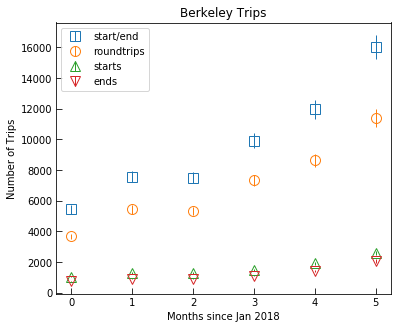

In [10]:
# Separate out the "starts" and "ends" from the "start/ends".
berk_startonly_list = [berk_trip_list[ii][0][((berk_trip_list[ii][0]['start_city']=='Berkeley') & (berk_trip_list[ii][0]['end_city']!='Berkeley'))] for ii in range(len(berk_trip_list))]
n_berk_startonly = [len(tab) for tab in berk_startonly_list]
berk_endonly_list = [berk_trip_list[ii][0][((berk_trip_list[ii][0]['end_city']=='Berkeley') & (berk_trip_list[ii][0]['start_city']!='Berkeley'))] for ii in range(len(berk_trip_list))]
n_berk_endonly = [len(tab) for tab in berk_endonly_list]

ms = 10 # markersize
ind_stop = 7
plt.figure(figsize=(6,5))
plt.errorbar(range(0, ind_stop-1), n_berk_trips[1:ind_stop], yerr=np.array(n_berk_trips[1:ind_stop])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(0, ind_stop-1), n_berk_only[1:ind_stop], yerr=np.array(n_berk_only[1:ind_stop])*0.05,
             label='roundtrips', color='C1', marker='o', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(0, ind_stop-1), n_berk_startonly[1:ind_stop], yerr=np.array(n_berk_startonly[1:ind_stop])*0.05,
             label='starts', color='C2', marker='^', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(0, ind_stop-1), n_berk_endonly[1:ind_stop], yerr=np.array(n_berk_endonly[1:ind_stop])*0.05,
             label='ends', color='C3', marker='v', markersize=ms, markerfacecolor='None', linestyle='None')
plt.title("Berkeley Trips")
plt.ylabel("Number of Trips")
plt.xlabel("Months since Jan 2018")
plt.legend(numpoints=1)
plt.show()

Ridership is clearly increasing over time. We'll need to fit a function to these data to find out just how quickly it's increasing and predict future ridership numbers.

The simplest function is a straight line: *y = ax + b*. We'll also try a basic exponential of the form *y = c + a exp(bx)*. We'll compare the goodness of fit with a simple $\chi^2_\nu$ (reduced chi-squared), where a smaller number represents a "better" fit and $\chi^2_\nu$=1.0 is a theoretically perfect fit.

Reduced chi^2, lin. fit = 5.332
Reduced chi^2, exp. fit = 2.240


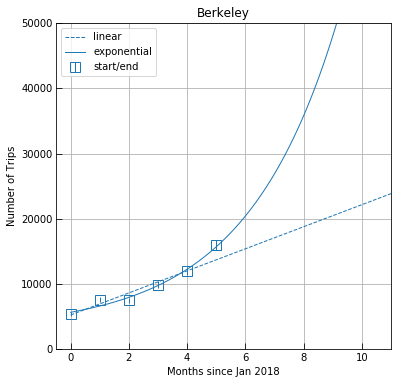

In [12]:
from scipy.optimize import curve_fit
pf_lin, cov_lin = curve_fit(lambda t,a,b: a*t+b,  np.arange(0.,ind_stop-1),  n_berk_trips[1:ind_stop],
          sigma=np.array(n_berk_trips[1:ind_stop])*0.05, p0=(1500., 3500.))
pf_exp, cov_exp = curve_fit(lambda t,a,b,c: c + a*np.exp(b*t),  range(0,ind_stop-1),  n_berk_trips[1:ind_stop],
          sigma=np.array(n_berk_trips[1:ind_stop])*0.05, p0=(700., 0.45, 5000.))

fit_lin = pf_lin[0]*np.arange(0.,6.) + pf_lin[1]
fit_exp = pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*np.arange(0.,6.))

chi2_red_lin = np.sum(((n_berk_trips[1:ind_stop] - fit_lin)/(np.array(n_berk_trips[1:ind_stop])*0.05))**2)/(6 - 2)
chi2_red_exp = np.sum(((n_berk_trips[1:ind_stop] - fit_exp)/(np.array(n_berk_trips[1:ind_stop])*0.05))**2)/(6 - 2)
print("Reduced chi^2, lin. fit = %.3f" % chi2_red_lin)
print("Reduced chi^2, exp. fit = %.3f" % chi2_red_exp)

t_extrap = np.linspace(0., 24., 500)
plt.figure(figsize=(6,6))
plt.errorbar(range(0,ind_stop-1), n_berk_trips[1:ind_stop], yerr=np.array(n_berk_trips[1:ind_stop])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
#plt.errorbar(range(7,len(n_berk_trips)), n_berk_trips[ind_stop:], yerr=np.array(n_berk_trips[ind_stop:])*0.05,
#             label='New Epochs', color='C2', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
plt.plot(t_extrap, pf_lin[0]*t_extrap + pf_lin[1], color='C0', linestyle='--', label='linear')
plt.plot(t_extrap, pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*t_extrap), label='exponential')
plt.ylim(0,50000)
plt.xlim(-0.5,11)
plt.ylabel("Number of Trips")
plt.xlabel("Months since Jan 2018")
plt.title("Berkeley")
plt.legend(numpoints=1)
plt.grid()
plt.show()

The $\chi^2_\nu$ is substantially lower for the exponential fit, although much of that difference appears to come from the linear fit not hitting the June point. What happens if we consider that point an outlier and remove it from the fit?

Reduced chi^2, lin. fit = 2.410
Reduced chi^2, exp. fit = 2.016


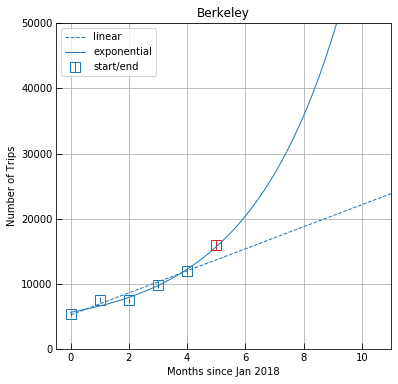

In [13]:
# Same as above, except exclude the June point from the fit.
from scipy.optimize import curve_fit
pf_lin_noJune, cov_lin_noJune = curve_fit(lambda t,a,b: a*t+b,  range(0,5),  n_berk_trips[1:ind_stop][:-1],
          sigma=np.array(n_berk_trips[1:ind_stop][:-1])*0.05, p0=(1500., 3500.))
pf_exp_noJune, cov_exp_noJune = curve_fit(lambda t,a,b,c: c + a*np.exp(b*t),  range(0,5),  n_berk_trips[1:ind_stop][:-1],
          sigma=np.array(n_berk_trips[1:ind_stop][:-1])*0.05, p0=(700., 0.45, 5000.))

fit_lin_noJune = pf_lin_noJune[0]*np.arange(0.,5.) + pf_lin_noJune[1]
fit_exp_noJune = pf_exp_noJune[2] + pf_exp_noJune[0]*np.exp(pf_exp_noJune[1]*np.arange(0.,5.))

chi2_red_lin_noJune = np.sum(((n_berk_trips[1:ind_stop][:-1] - fit_lin_noJune)/(np.array(n_berk_trips[1:ind_stop][:-1])*0.05))**2)/(6 - 2)
chi2_red_exp_noJune = np.sum(((n_berk_trips[1:ind_stop][:-1] - fit_exp_noJune)/(np.array(n_berk_trips[1:ind_stop][:-1])*0.05))**2)/(6 - 2)
print("Reduced chi^2, lin. fit = %.3f" % chi2_red_lin_noJune)
print("Reduced chi^2, exp. fit = %.3f" % chi2_red_exp_noJune)

t_extrap_noJune = np.linspace(0., 25., 500)
plt.figure(figsize=(6,6))
plt.errorbar(range(0,5), n_berk_trips[1:ind_stop][:-1], yerr=np.array(n_berk_trips[1:ind_stop][:-1])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
# Show the omitted data point in red, just for comparison.
plt.errorbar(5, n_berk_trips[1:ind_stop][-1], yerr=np.array(n_berk_trips[1:ind_stop][-1])*0.05,
             color='C3', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
#plt.errorbar(range(7,len(n_berk_trips)), n_berk_trips[ind_stop:], yerr=np.array(n_berk_trips[ind_stop:])*0.05,
#             label='New Epochs', color='C2', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
plt.plot(t_extrap_noJune, pf_lin[0]*t_extrap_noJune + pf_lin[1], color='C0', linestyle='--', label='linear')
plt.plot(t_extrap_noJune, pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*t_extrap_noJune), color='C0', label='exponential')
plt.ylim(0,50000)
plt.xlim(-0.5,11)
plt.ylabel("Number of Trips")
plt.xlabel("Months since Jan 2018")
plt.title("Berkeley")
plt.legend(numpoints=1)
plt.grid()
plt.show()

Even when excluding June an exponential function still appears to describe the data better than a linear function, but the rise in trips is slower when based on only the first five months of 2018.

So, depending on whether we include that June 2018 point, we get very different predictions for the number of start/end Berkeley trips that will be taken in October 2018 assuming exponential growth: either ~31,000 or nearly 48,000, respectively for the two cases.

And now we have the data from July 2018 and beyond to test our predictions! Below are the same plots as above but with the latest data points added in green.

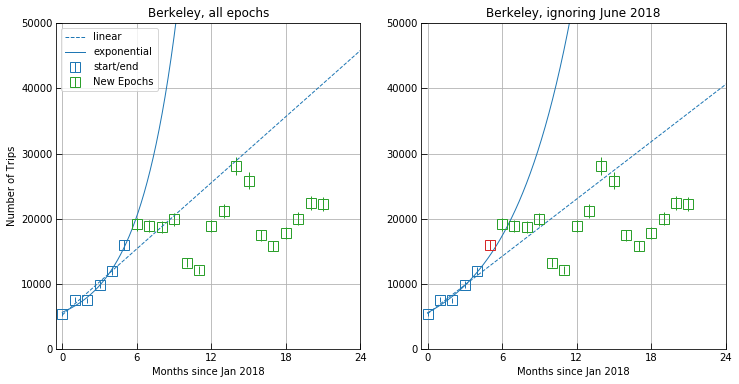

In [21]:
# Same fits as above to the data, first including and then excluding June 2018, except now we also
# show the later data points in green.

#chi2_red_lin_noJune = np.sum(((n_berk_trips[1:ind_stop][:-1] - fit_lin_noJune)/(np.array(n_berk_trips[1:ind_stop][:-1])*0.05))**2)/(6 - 2)
#chi2_red_exp_noJune = np.sum(((n_berk_trips[1:ind_stop][:-1] - fit_exp_noJune)/(np.array(n_berk_trips[1:ind_stop][:-1])*0.05))**2)/(6 - 2)
#print("Reduced chi^2, lin. fit = %.3f" % chi2_red_lin_noJune)
#print("Reduced chi^2, exp. fit = %.3f" % chi2_red_exp_noJune)

#plt.figure(figsize=(6,6))
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.errorbar(range(0,ind_stop-1), n_berk_trips[1:ind_stop], yerr=np.array(n_berk_trips[1:ind_stop])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
ax0.errorbar(range(6,len(n_berk_trips)-1), n_berk_trips[ind_stop:], yerr=np.array(n_berk_trips[ind_stop:])*0.05,
             label='New Epochs', color='C2', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
ax0.plot(t_extrap, pf_lin[0]*t_extrap + pf_lin[1], color='C0', linestyle='--', label='linear')
ax0.plot(t_extrap, pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*t_extrap), label='exponential')
ax0.set_xticks(np.linspace(0,30,6))
ax0.set_ylim(0,50000)
ax0.set_xlim(-0.5,24)
ax0.set_ylabel("Number of Trips")
ax0.set_xlabel("Months since Jan 2018")
ax0.set_title("Berkeley, all epochs")
ax0.legend(numpoints=1)
ax0.grid()

ax1.errorbar(range(0,5), n_berk_trips[1:ind_stop][:-1], yerr=np.array(n_berk_trips[1:ind_stop][:-1])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
# Show the omitted data point in red, just for comparison.
ax1.errorbar(5, n_berk_trips[1:ind_stop][-1], yerr=np.array(n_berk_trips[1:ind_stop][-1])*0.05,
             color='C3', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
ax1.errorbar(range(6,len(n_berk_trips)-1), n_berk_trips[ind_stop:], yerr=np.array(n_berk_trips[ind_stop:])*0.05,
             label='New Epochs', color='C2', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
ax1.plot(t_extrap_noJune, pf_lin_noJune[0]*t_extrap_noJune + pf_lin_noJune[1], color='C0', linestyle='--', label='linear')
ax1.plot(t_extrap_noJune, pf_exp_noJune[2] + pf_exp_noJune[0]*np.exp(pf_exp_noJune[1]*t_extrap_noJune), color='C0', label='exponential')
ax1.set_xticks(np.linspace(0,30,6))
ax1.set_ylim(0,50000)
ax1.set_xlim(-0.5,24)
#ax1.set_ylabel("Number of Trips")
ax1.set_xlabel("Months since Jan 2018")
ax1.set_title("Berkeley, ignoring June 2018")
#ax1.legend(numpoints=1)
ax1.grid()
plt.show()

The recent data rule out an exponential growth rate in the number of Berkeley trips. That's fine-- such growth was unrealistic anyway. Rather than a pure linear growth rate, however, the number of trips fluctuates and appears somewhat cyclical around the UC Berkeley schedule and annual weather patterns.

In 2019, trips peaked in April and May: warm, dry months when UC Berkeley students are still around. Those months actually fall near the linear growth projection that ignored June 2018. The station data are incomplete for June and July, so we will consider them lower limits. Trips rise from August to September (when students are back in town) and then maybe level off in October when the weather starts to cool off.

Overall, the data suggest a more complex model is needed to predict the number of trips in Berkeley taken in a given month. A next attempt might consider a combination of a spline or polynomial function that describes the annual cycle and a broken power-law that describes the long-term growth (fast early on and slower once the program had settled in).

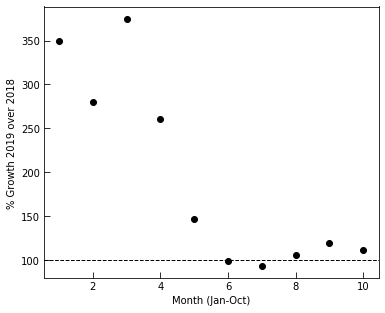

[349.0872211  280.38024822 374.72351765 260.92929293 146.31860776
  98.51463521  93.19155607 105.90945195 119.34779134 111.62534435]


In [37]:
# Year-over-year growth by month.
yoy = np.array(n_berk_trips[13:])/np.array(n_berk_trips[1:11])

plt.figure(figsize=(6,5))
plt.plot(range(1,len(yoy)+1), 100*yoy, 'ko')
plt.axhline(y=100, color='k', linestyle='--')
plt.ylabel('% Growth 2019 over 2018')
plt.xlabel('Month (Jan-Oct)')
plt.draw()
plt.show()

print(100*yoy)

Looking at year-over-year growth, we find that more trips are being taken in 2019 than were in 2018. June and July 2019 look weak but are incomplete, so they almost certainly showed growth. Just considering August through October, trips are up ~6%-19% compared to 2018. Use is growing, but not explosively.

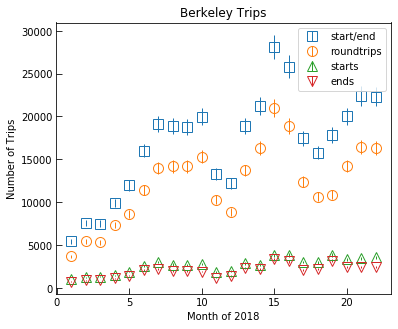

In [38]:
# Separate out the "starts" and "ends" from the "start/ends".
berk_startonly_list = [berk_trip_list[ii][0][((berk_trip_list[ii][0]['start_city']=='Berkeley') & (berk_trip_list[ii][0]['end_city']!='Berkeley'))] for ii in range(len(berk_trip_list))]
n_berk_startonly = [len(tab) for tab in berk_startonly_list]
berk_endonly_list = [berk_trip_list[ii][0][((berk_trip_list[ii][0]['end_city']=='Berkeley') & (berk_trip_list[ii][0]['start_city']!='Berkeley'))] for ii in range(len(berk_trip_list))]
n_berk_endonly = [len(tab) for tab in berk_endonly_list]

ms = 10 # markersize
ind_stop = None
plt.figure(figsize=(6,5))
plt.errorbar(range(1, N_ep), n_berk_trips[1:ind_stop], yerr=np.array(n_berk_trips[1:ind_stop])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(1, N_ep), n_berk_only[1:ind_stop], yerr=np.array(n_berk_only[1:ind_stop])*0.05,
             label='roundtrips', color='C1', marker='o', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(1, N_ep), n_berk_startonly[1:ind_stop], yerr=np.array(n_berk_startonly[1:ind_stop])*0.05,
             label='starts', color='C2', marker='^', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(1, N_ep), n_berk_endonly[1:ind_stop], yerr=np.array(n_berk_endonly[1:ind_stop])*0.05,
             label='ends', color='C3', marker='v', markersize=ms, markerfacecolor='None', linestyle='None')
plt.title("Berkeley Trips")
plt.ylabel("Number of Trips")
plt.xlabel("Month of 2018")
plt.legend(numpoints=1)
plt.show()

### Time Distributions

Date and time statistics are also included, so we can figure out the bike usage as a function of time of day, day of week, and also average trip duration.

In [39]:
# Average trip duration.
avg_durations_all = [np.mean(tables[ii]['duration_sec']/60.) for ii in range(len(tables))]
avg_durations_berk = [np.mean(berk_trip_list[ii][0]['duration_sec']/60.) for ii in range(len(berk_trip_list))] # [minutes]
print("Average trip durations (minutes)")
print("Epoch     :   2017  01/18 02/18 03/18 04/18 05/18 06/18 07/18 08/18 09/18 10/18")
print("All cities: ", np.round(avg_durations_all, decimals=2))
print("Berkeley  : ", np.round(avg_durations_berk, decimals=2))

print(np.round(np.mean(avg_durations_berk[1:13]), decimals=2))
print(np.round(np.mean(avg_durations_berk[13:]), decimals=2))

Average trip durations (minutes)
Epoch     :   2017  01/18 02/18 03/18 04/18 05/18 06/18 07/18 08/18 09/18 10/18
All cities:  [18.32 14.52 14.64 14.51 14.77 14.25 15.13 15.13 14.52 14.67 13.42 12.63
 12.84 12.52 12.1  13.46 13.38 13.2  14.03 14.03 13.89 14.07 13.77]
Berkeley  :  [21.74 14.76 14.77 13.67 14.89 14.8  14.85 14.18 12.86 12.81 11.73 11.11
 11.82 11.31 10.31 11.69 12.2  12.65 13.47 12.69 12.88 12.1  12.2 ]
13.52
12.15


With an average trip duration of just under 15 minutes, Berkeley falls right in line with the rest of the Bay Area. Trips were 4-5 minutes longer in 2017 than 2018, which is intriguing, but for now we'll file it away as a curiosity and move on.

Next we'll look at how trips are distributed over the days of the week.

Weekday average = 15.3%
Weekend average = 11.7%


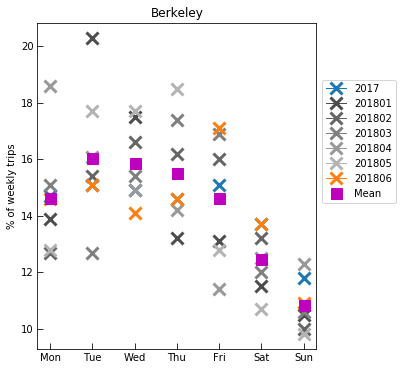

In [40]:
epoch_colors = ['C0', '0.3', '0.4', '0.5', '0.6', '0.7', 'C1']
epochs_by_day = []
fig = plt.figure(figsize=(5,6))
ax = plt.subplot(111)
for ep in range(0,7):
    epochs_by_day.append([])
    for dd, day in enumerate(days_of_week):
        if (dd==0):
            lab = epoch_names[ep]
        else:
            lab = None
        percent_trips = np.round(100*len(berk_trip_list[ep][0][berk_trip_list[ep][0]['start_day']==day])/len(berk_trip_list[ep][0]), decimals=1)
        #print(day, percent_trips)
        epochs_by_day[ep].append(percent_trips)
        ax.plot(dd, percent_trips, marker='x', color=epoch_colors[ep], markersize=ms+2, markeredgewidth=3, label=lab)
    #print("\n")
ax.set_ylabel("% of weekly trips")
ax.set_xticks(range(0,7))
ax.set_title("Berkeley")
ax.set_xticklabels(days_of_week)

# Get mean percentages for each day across all epochs.
mean_by_day = np.mean(epochs_by_day, axis=0)
print("Weekday average = %.1f%%" % np.mean(mean_by_day[0:5]))
print("Weekend average = %.1f%%" % np.mean(mean_by_day[5:]))

ax.plot(range(0,7), mean_by_day, marker='s', color='m', markersize=ms+1, linestyle='None', label='Mean')

ax.legend(numpoints=1, loc=(1.02,0.45))
plt.draw()

People are using the bikes primarily on weekdays, with rides peaking on Tuesdays (16.5% of weekly rides) and declining through Friday, then really dropping off over the weekend. Mondays are a bit lackluster, which could be due to holidays and people taking long weekends (Friday is the next lowest weekday) or maybe a preference for other transportation to start the work week. Still, the number of trips is fairly constant across weekdays while weekend usage is significantly lower: ridership drops by ~28% compared to weekdays.

I take this split to mean that work-related uses (e.g. daily commutes) make up an important fraction of trips. It's especially notable given that public transportation typically runs less frequently and during fewer hours on weekends, which might boost bikeshare usage during that time.

We can test the commuter hypothesis by examining trip number as a function of start/end time.

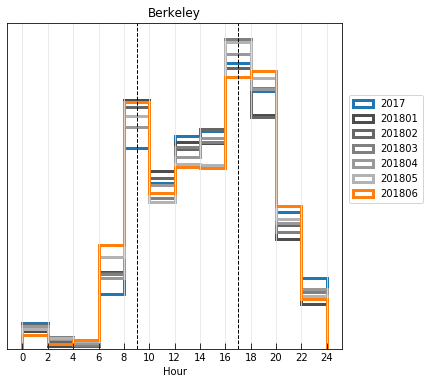

In [41]:
hists = []
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for ep in range(0,7):
    histout = ax.hist(berk_trip_list[ep][0]['start_hr'], bins=np.arange(0, 25, 2), histtype='step', color=epoch_colors[ep],
            linewidth=3, density=True, label=epoch_names[ep])
    hists.append(histout)
#ax.hist(np.mean([hists[ii][0] for ii in range(0,7)], axis=0), range=(0, 25), density=True, histtype='step', color='m',
#            linewidth=3, label='Mean')
ax.yaxis.set_visible(False)
ax.set_xticks(np.arange(0, 25, 2))
ax.grid(which='major', axis='x', c='0.9')
ax.axvline(x=9, color='k', linestyle='--')
ax.axvline(x=17, color='k', linestyle='--')
ax.set_xlabel("Hour")
ax.set_title("Berkeley")
ax.legend(numpoints=1, loc=(1.02,0.45))
plt.draw()

Indeed, the trips peak during the morning and afternoon commutes (dashed lines mark 9 AM and 5 PM). The distribution of trip end times is basically the same, so I won't bother plotting it (this makes sense given the 15 minute average trip time).

### Rider Demographics

Rider birthdate and gender are collected for most trips, so we can partially examine those aspects of the people using the GoBike system.

In [42]:
# To Do: Look at rider age?? Change over time??

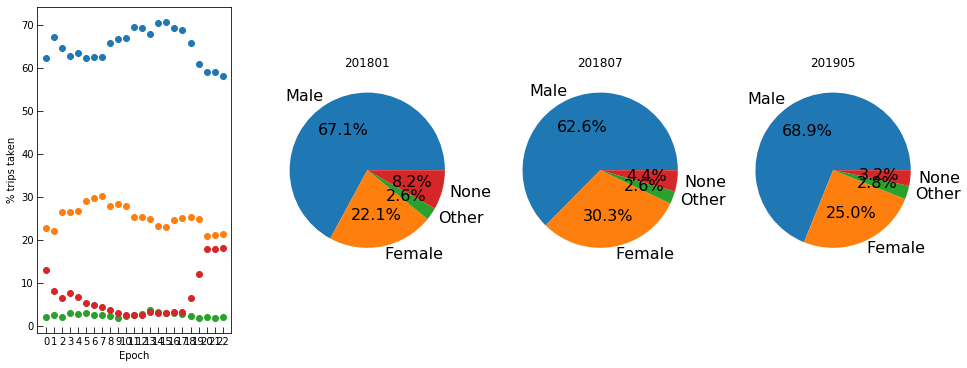

In [71]:
# Compare Berkeley trip-takers by gender.
gender_labels = ['Male', 'Female', 'Other', 'None']
genders = ['Male', 'Female', 'Other', 'None']
berk_trips_m_f = []
plt.figure(figsize=(16,6))
ax0 = plt.subplot(141)
for ep in range(0,N_ep):
    berk_trip_list[ep][0]['member_gender'][berk_trip_list[ep][0]['member_gender'] == 'M'] = 'Male'
    berk_trip_list[ep][0]['member_gender'][berk_trip_list[ep][0]['member_gender'] == 'F'] = 'Female'
    berk_trip_list[ep][0]['member_gender'][berk_trip_list[ep][0]['member_gender'].mask] = 'None'
    berk_trip_list[ep][0]['member_gender'][berk_trip_list[ep][0]['member_gender'] == ''] = 'None'
    berk_trips_m_f.append([len(berk_trip_list[ep][0][berk_trip_list[ep][0]['member_gender'] == gen]) for gen in genders])
    ax0.plot(ep, 100*berk_trips_m_f[-1][0]/np.sum(berk_trips_m_f[-1]), c='C0', marker='o', label='Male')
    ax0.plot(ep, 100*berk_trips_m_f[-1][1]/np.sum(berk_trips_m_f[-1]), c='C1', marker='o', label='Female')
    ax0.plot(ep, 100*berk_trips_m_f[-1][2]/np.sum(berk_trips_m_f[-1]), c='C2', marker='o', label='Other')
    ax0.plot(ep, 100*berk_trips_m_f[-1][3]/np.sum(berk_trips_m_f[-1]), c='C3', marker='o', label='None')
    #print("Epoch", ep)
    #print(100*berk_trips_m_f[-1][0]/np.sum(berk_trips_m_f[-1]))
    #print(100*berk_trips_m_f[-1][1]/np.sum(berk_trips_m_f[-1]))
    #print(100*berk_trips_m_f[-1][2]/np.sum(berk_trips_m_f[-1]))
ax0.set_yticks(np.arange(0,80,10))
ax0.set_xticks(np.arange(0,N_ep,1))
ax0.set_ylabel("% trips taken")
ax0.set_xlabel("Epoch")
#ax0.legend(numpoints=1)

# Draw pie charts of gender distribution.
ax1 = plt.subplot(142)
ax1.pie(berk_trips_m_f[1], labels=gender_labels, autopct='%.1f%%', textprops={'fontsize':16},
       startangle=0)
ax1.set_aspect('equal')
ax1.set_title(epoch_names[1])
ax3 = plt.subplot(143)
ax3.pie(berk_trips_m_f[7], labels=gender_labels, autopct='%.1f%%', textprops={'fontsize':16},
       startangle=0)
ax3.set_aspect('equal')
ax3.set_title(epoch_names[7])
ax2 = plt.subplot(144)
ax2.pie(berk_trips_m_f[-6], labels=gender_labels, autopct='%.1f%%', textprops={'fontsize':16},
       startangle=0)
ax2.set_aspect('equal')
ax2.set_title(epoch_names[-6])
plt.draw()

Men dominate the usage, accounting for ~58%--70% of trips. Interestingly, the percentage of women riders increased monthly from 22% in January 2018 to ~30% in July 2018 but decreased afterwards to 25% by May 2019. The fraction of riders with no reported gender ("None") decreased from 8% to 3% between January 2018 and October 2018 (when it leveled out), so some of the "new" female riders in early 2018 may not be new at all but just newly reporting as female. Still, this can't account for all of the increase in female ridership or the simultaneous decrease in male ridership. The percentage of riders reporting their gender as neither Male nor Female (termed "Other" in the data) has been approximately constant at 2.5%--3.0%. The number of unreported genders spikes suddenly in June 2019 when the program changed from GoBike to Bay Wheels, indicating that something changed in the way gender information is collected, so later values are unreliable at the moment.

Did women hesitate to use the service for some reason when it first arrived? Maybe program advertisements didn't reach women as effectively as men early on? Or, because stations were added to the system incrementally, perhaps the original stations were located in areas more frequently trafficked by men? But then why did women start using the service less again?

The question of unequal station positioning might be something we can explore further with our data by breaking down trips according to station location.

### Location Usage

Which stations are most heavily used? How do they break down by gender and age? How has station usage changed with time?

In [73]:
# The useful collections.Counter function returns a nice dictionary with the number of occurrences for each station id.
from collections import Counter
start_station_counts = Counter(np.array(tables[-1]['start_station_id']))
end_station_counts = Counter(np.array(tables[-1]['end_station_id']))
start_station_berk_counts = Counter(np.array(berk_trip_list[-1][0]['start_station_id']))
end_station_berk_counts = Counter(np.array(berk_trip_list[-1][0]['end_station_id']))
start_coords = []
end_coords = []

print("Data for epoch %s" % epoch_names[-1])

# Even more handy, the Counter dict has a special method to return the N most common elements.
print("\nTop 10 starting stations (Berkeley trips only):")
for ss in start_station_berk_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))

print("\nTop 10 ending stations (Berkeley trips only):")
for ss in end_station_berk_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))

print("\nTop 10 starting stations (entire network):")
for ss in start_station_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))
        start_coords.append((stations[stations['id']==ss[0]]['lat'].data[0], stations[stations['id']==ss[0]]['lon'].data[0]))

print("\nTop 10 ending stations (entire network):")
for ss in end_station_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))
        end_coords.append((stations[stations['id']==ss[0]]['lat'].data[0], stations[stations['id']==ss[0]]['lon'].data[0]))

Data for epoch 201910

Top 10 starting stations (Berkeley trips only):
	Berkeley, Bancroft Way at College Ave: 1664 rides
	Berkeley, Bancroft Way at Telegraph Ave: 1563 rides
	Berkeley, Downtown Berkeley BART: 1266 rides
	Berkeley, Hearst Ave at Euclid Ave: 1149 rides
	Berkeley, Haste St at College Ave: 965 rides
	Berkeley, Haste St at Telegraph Ave: 964 rides
	Berkeley, Ashby BART Station: 936 rides
	Berkeley, Parker St at Fulton St: 728 rides
	Berkeley, Derby St at College Ave: 645 rides
	Berkeley, Fulton St at Bancroft Way: 602 rides

Top 10 ending stations (Berkeley trips only):
	Berkeley, Downtown Berkeley BART: 1484 rides
	Berkeley, Bancroft Way at Telegraph Ave: 1451 rides
	Berkeley, Ashby BART Station: 976 rides
	Berkeley, Parker St at Fulton St: 872 rides
	Berkeley, MLK Jr Way at University Ave: 807 rides
	Berkeley, Channing Way at Shattuck Ave: 786 rides
	Berkeley, Berkeley Civic Center: 715 rides
	Berkeley, University Ave at Oxford St: 694 rides
	Berkeley, Fulton St at Bancr

Unsurprisingly, the most heavily used Berkeley stations are near the UC Berkeley campus and at BART stations. Other hotspots include downtown Berkeley (e.g., the Civic Center) and food centers (e.g., Telegraph Ave on campus' southside, and MLK Jr. Way & University Ave near a Trader Joe's). The 4th St. area also gets attention, though the main attractor there may be the Amtrak station; most rides start or end at 4th & Addison (near the station) rather than at 5th & Delaware (closer to the shops). A couple of the remaining stations seem to be in mostly residential areas that may house lots of UC Berkeley students: Parker St. & Fulton St. and Derby St. & College Ave (with the latter also being the site of Sack's Coffee House).

There are other things to look into: the least-used stations, gender splits at stations, times of use at stations, how many unique riders there are, which single bike has made the most/longest trips, and more that I haven't thought of yet.

